# IESB - Miner II - Aula 08 - Classes desbalanceadas

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bank-marketing/bank-additional-names.txt
/kaggle/input/bank-marketing/bank-additional-full.csv


# Parte 1
## Tratamento de dados e execução do modelo

In [2]:
# Importando os dados
df = pd.read_csv('/kaggle/input/bank-marketing/bank-additional-full.csv', sep=';')

df.shape

(41188, 21)

In [3]:
# Verificando quantidades e tipos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [4]:
# Visualizando os dados
df.head().T

,0,1,2,3,4
age,56,57,37,40,56
job,housemaid,services,services,admin.,services
marital,married,married,married,married,married
education,basic.4y,high.school,high.school,basic.6y,high.school
default,no,unknown,no,no,no
housing,no,no,yes,no,no
loan,no,no,no,no,yes
contact,telephone,telephone,telephone,telephone,telephone
month,may,may,may,may,may
day_of_week,mon,mon,mon,mon,mon


In [5]:
# Não temos valores nulos mas temos dados como 'unknown'
# Para facilitar vamos considerar esses dados como um tipo específico
df['job'].value_counts()

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64

In [6]:
# Verificando também a coluna 'loan'
df['loan'].value_counts()

no         33950
yes         6248
unknown      990
Name: loan, dtype: int64

In [7]:
# O problema da variável 'duration' - data leak
df.drop(columns=['duration'],axis=1, inplace=True)

In [8]:
# Convertendo as colunas object para colunas categóricas
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category').cat.codes
        
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  int8   
 2   marital         41188 non-null  int8   
 3   education       41188 non-null  int8   
 4   default         41188 non-null  int8   
 5   housing         41188 non-null  int8   
 6   loan            41188 non-null  int8   
 7   contact         41188 non-null  int8   
 8   month           41188 non-null  int8   
 9   day_of_week     41188 non-null  int8   
 10  campaign        41188 non-null  int64  
 11  pdays           41188 non-null  int64  
 12  previous        41188 non-null  int64  
 13  poutcome        41188 non-null  int8   
 14  emp.var.rate    41188 non-null  float64
 15  cons.price.idx  41188 non-null  float64
 16  cons.conf.idx   41188 non-null  float64
 17  euribor3m       41188 non-null 

In [9]:
# Separando o dataframe
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.20, random_state=42)

train.shape, test.shape

((32950, 20), (8238, 20))

In [10]:
# Lista das colunas a serem usadas para treino
feats = [c for c in df.columns if c not in ['y']]

In [11]:
# Importando o RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

# Instanciando um objeto RandomForest
rf = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)

# Treinando o modelo
rf.fit(train[feats], train['y'])

RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)

In [12]:
# Fazer previsões usando o modelo treinado
preds = rf.predict(test[feats])

# Importando a métrica
from sklearn.metrics import accuracy_score

# Avaliando o modelo com relação aos dados de teste
accuracy_score(test['y'], preds)

0.8917212915756252

In [13]:
# Verificando a distribuição da variável target
df['y'].value_counts()

0    36548
1     4640
Name: y, dtype: int64

In [14]:
# Verificando a distribuição da variável target (%)
df['y'].value_counts(normalize=True)

0    0.887346
1    0.112654
Name: y, dtype: float64

In [15]:
# Verificando a distribuição da variável target (%) - Base de treino
train['y'].value_counts(normalize=True)

0    0.887557
1    0.112443
Name: y, dtype: float64

In [16]:
# Verificando a distribuição da variável target (%) - Base de teste
test['y'].value_counts(normalize=True)

0    0.886502
1    0.113498
Name: y, dtype: float64

## Confusion Matrix

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

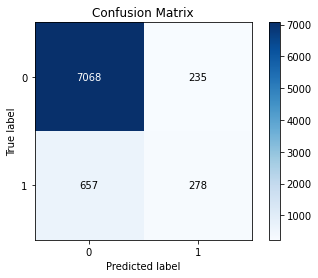

In [17]:
# Importando uma biblioteca específica para plotar gráficos relacionada
# com o scikitlearn
import scikitplot as skplt

# Matriz de Confusão - Dados de teste
skplt.metrics.plot_confusion_matrix(test['y'], preds)

# Parte 2
## Tratando classes desbalanceadas

## Fazendo Random Under-Sampling e Random Over-Sampling
Vamos usar o própio sklearn para realizar under e over sampling de forma aleatória

In [18]:
# Importando a biblioteca
from sklearn.utils import resample

# Separando os dados de acordo com a classificação
df_no = df[df['y'] == 0]
df_yes = df[df['y'] == 1]

df_no.shape, df_yes.shape

((36548, 20), (4640, 20))

### Random Over-Sampling 

In [19]:
# Over-Sampling
df_yes_over = resample(df_yes, # vamos aumentar a classe menor
                       replace=True, # sample com replacement
                       n_samples=len(df_no), # igualando a maior classe
                       random_state=42)

# juntando os dados
df_over= pd.concat([df_no, df_yes_over])

# check new class counts
df_over['y'].value_counts()

0    36548
1    36548
Name: y, dtype: int64

In [20]:
# Executando o modelo com df_over

# Dividindo em treino e teste
train, test = train_test_split(df_over, test_size=0.2, random_state=42)

# Treinar o modelo
rf.fit(train[feats], train['y'])

# Previsões na base de teste
preds_test = rf.predict(test[feats])

# Medir a acurácia
accuracy_score(test['y'], preds_test)

0.9652530779753762

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

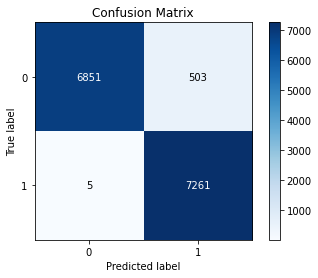

In [21]:
# Plotando a matriz de confusao para os dados de teste
skplt.metrics.plot_confusion_matrix(test['y'], preds_test)

### Random Under-Sampling

In [22]:
# Under-Sampling
df_no_under = resample(df_no, # vamos diminuir a classe menor
                       replace=False, # sample sem replacement
                       n_samples=len(df_yes), # igualando a menor classe
                       random_state=42)

# juntando os dados
df_under= pd.concat([df_no_under, df_yes])

# check new class counts
df_under['y'].value_counts()

0    4640
1    4640
Name: y, dtype: int64

In [23]:
# Executando o modelo com df_under

# Dividindo em treino e teste
train, test = train_test_split(df_under, test_size=0.2, random_state=42)

# Treinar o modelo
rf.fit(train[feats], train['y'])

# Previsões na base de teste
preds_test = rf.predict(test[feats])

# Medir a acurácia
accuracy_score(test['y'], preds_test)

0.7230603448275862

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

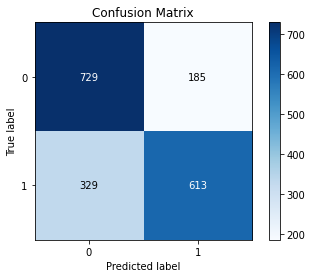

In [24]:
# Plotando a matriz de confusao para os dados de teste
skplt.metrics.plot_confusion_matrix(test['y'], preds_test)

## Usando a bilioteca imbalanced-learn
Essa biblioteca implementa diversos modelos diferentes para tratar classes desabalanceadas

In [25]:
# Importando a biblioteca
import imblearn

In [26]:
# Separando os dados de entrada e o target
X, y = df[feats], df[['y']]

### Imblearn Random Over-Sampling

In [27]:
# Importando a biblioteca
from imblearn.over_sampling import RandomOverSampler

# Fazendo o over-sampling
ros = RandomOverSampler(random_state=42)
X_ros,y_ros= ros.fit_resample(X,y)

# Verificando os dados
y_ros['y'].value_counts()

0    36548
1    36548
Name: y, dtype: int64

In [28]:
# Executando o modelo com imblearn over-sampling

# Juntando os dados
df_over = pd.concat([X_ros, y_ros], axis=1)

# Dividindo em treino e teste
train, test = train_test_split(df_over, test_size=0.2, random_state=42)

# Treinar o modelo
rf.fit(train[feats], train['y'])

# Previsões na base de teste
preds_test = rf.predict(test[feats])

# Medir a acurácia
accuracy_score(test['y'], preds_test)

0.9636114911080711

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

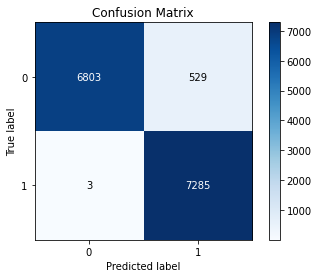

In [29]:
# Plotando a matriz de confusao para os dados de teste
skplt.metrics.plot_confusion_matrix(test['y'], preds_test)

### Imblearn Tomek-links (under-sampling)

In [30]:
# Importando a biblioteca
from imblearn.under_sampling import TomekLinks

# Fazendo o under-sampling
tl = TomekLinks()
X_tl, y_tl = tl.fit_resample(X,y)

# Verificando os dados
y_tl['y'].value_counts()

0    35169
1     4640
Name: y, dtype: int64

In [31]:
# Executando o modelo com Tomek-links

# Juntando os dados
df_under = pd.concat([X_tl, y_tl], axis=1)

# Dividindo em treino e teste
train, test = train_test_split(df_under, test_size=0.2, random_state=42)

# Treinar o modelo
rf.fit(train[feats], train['y'])

# Previsões na base de teste
preds_test = rf.predict(test[feats])

# Medir a acurácia
accuracy_score(test['y'], preds_test)

0.9024114544084401

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

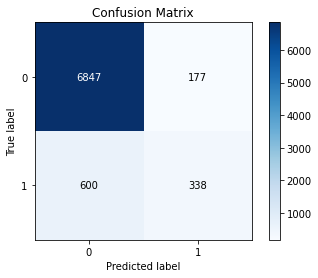

In [32]:
# Plotando a matriz de confusao para os dados de teste
skplt.metrics.plot_confusion_matrix(test['y'], preds_test)

### Imblearn SMOTE (over-sampling)

In [33]:
# Importando a biblioteca
from imblearn.over_sampling import SMOTE

# Fazendo o under-sampling
sm = SMOTE()
X_sm, y_sm = sm.fit_resample(X,y)

# Verificando os dados
y_sm['y'].value_counts()

0    36548
1    36548
Name: y, dtype: int64

In [34]:
# Executando o modelo com SMOTE

# Juntando os dados
df_over = pd.concat([X_sm, y_sm], axis=1)

# Dividindo em treino e teste
train, test = train_test_split(df_over, test_size=0.2, random_state=42)

# Treinar o modelo
rf.fit(train[feats], train['y'])

# Previsões na base de teste
preds_test = rf.predict(test[feats])

# Medir a acurácia
accuracy_score(test['y'], preds_test)

0.9285225718194254

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

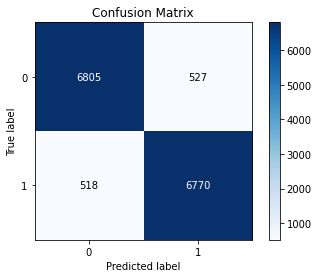

In [35]:
# Plotando a matriz de confusao para os dados de teste
skplt.metrics.plot_confusion_matrix(test['y'], preds_test)